In [289]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.polynomial.legendre as leg

Set up classes

In [290]:
class flux:
    def __init__(self):
        self.moments = np.zeros((2,10))

In [291]:
class fission:
    def __init__(self):
        fission.k = 1
        fission.source = np.ones(10)

In [292]:
class material:
    def __init__(self, nuSigmaF, SigmaS, SigmaR, D, fL, fR):
        self.nuSigmaF = nuSigmaF
        self.SigmaS = SigmaS
        self.SigmaR = SigmaR
        self.D = D
        self.fL = fL
        self.fR = fR

In [293]:
class cell:
    def __init__(self, left, right, material):
        self.left = left
        self.right = right
        self.material = material

In [294]:
class mesh:
    def __init__(self, dx):
        self.dx = dx

In [295]:
class lhs:
    def __init__(self):
        self.thermal = None
        self.fast = None

In [296]:
class functions:
    def __init__(self):
        self.left_thermal = None
        self.right_thermal = None
        self.left_fast = None
        self.left_fast = None

Set up functions

In [297]:
def pi_rate(new, old):
    rate = np.amax(abs(new - old))
    return rate

In [298]:
def pi_convergence(new, old, new_pi_rate, old_pi_rate):
    # convergence criteria
    epi = 1e-5
    
    # calculate convergence rate
    rho = new_pi_rate / old_pi_rate

    if np.amax(abs(new - old)) < epi * (1 - rho):
        return True
    else:
        return False

In [299]:
def k_rate(new, old):
    rate = abs(new - old)
    return rate

In [300]:
def k_convergence(new, old, new_k_rate, old_k_rate):
    # convergence criteria
    ek = 1e-5

    # calculate convergence rate
    rho = new_k_rate / old_k_rate

    if abs(new - old) < ek * (1 - rho):
        return True
    else:
        return False

In [301]:
def build_lhs():
    # energy groups
    for g in range(2):
        # read in data
        d1 = node1.material.D[g]
        d2 = node2.material.D[g]
        dx = mesh1.dx
        fr1 = node1.material.fR[g]
        fl2 = node2.material.fL[g]
        SigmaR1 = node1.material.SigmaR[g]
        SigmaR2 = node2.material.SigmaR[g]

        # build matrix
        matrix = np.zeros((10,10))
        matrix[0,:] = [0, 1, -3, 6, -10, 0, 0, 0, 0, 0]
        matrix[1,:] = [0, 0, 0, 0, 0, 0, 1, 3, 6, 10]
        matrix[2,:] = [0, d1/dx, 3*d1/dx, 6*d1/dx, 10*d1/dx, 0, -d2/ dx, 3*d2/dx, -6*d2/dx, 10*d2/dx]
        matrix[3,:] = [fr1, fr1, fr1, fr1, fr1, -fl2, fl2, -fl2, fl2, -fl2]
        matrix[4,:] = [SigmaR1, 0, -12*d1/(dx*dx), 0, -40*d1/(dx*dx), 0, 0, 0, 0, 0]
        matrix[5,:] = [0, 0, 0, 0, 0, SigmaR2, 0, -12*d2/(dx*dx), 0, -40*d2/(dx*dx)]
        matrix[6,:] = [0, SigmaR1, 0, -60*d1/(dx*dx), 0, 0, 0, 0, 0, 0]
        matrix[7,:] = [0, 0, 0, 0, 0, 0, SigmaR2, 0, -60*d2/(dx*dx), 0]
        matrix[8,:] = [0, 0, SigmaR1, 0, -140*d1/(dx*dx), 0, 0, 0, 0, 0]
        matrix[9,:] = [0, 0, 0, 0, 0, 0, 0, SigmaR2, 0, -140*d2/(dx*dx)]

        # assign to class
        if g == 0:
            lhs1.fast = matrix.copy()
        if g == 1:
            lhs1.thermal = matrix.copy()

In [302]:
def build_rhs(g):
    if g == 0: # fast
        k = fission1.k
        source = fission1.source
        F10 = source[0]
        F20 = source[5]
        F11 = source[1]
        F21 = source[6]
        F12 = source[2]
        F22 = source[7]
        
        rhs = np.array((0, 0, 0, 0, 1/k * F10, 1/k * F20, 1/k * F11, 1/k * F21, 1/k * F12, 1/k * F22))
    if g == 1: # thermal
        SigmaS1 = node1.material.SigmaS[1]
        #SigmaS2 = node2.material.SigmaS[1]
        f110 = flux1.moments[0,0]
        f120 = flux1.moments[0,5]
        f111 = flux1.moments[0,1]
        f121 = flux1.moments[0,6]
        f112 = flux1.moments[0,2]
        f122 = flux1.moments[0,7]
    
        rhs =  np.array((0, 0, 0, 0, SigmaS1 * f110,  SigmaS1 * f120, SigmaS1 * f111, SigmaS1 * f121, SigmaS1 * f112, SigmaS1 * f122))
    return rhs

In [303]:
def solve(g, lhs, rhs):
    flux1.moments[g,:] = np.linalg.solve(lhs, rhs)

In [304]:
def calculate_fission_source():
    # get flux values
    fast_flux = flux1.moments[0,:]
    thermal_flux = flux1.moments[1,:]

    # node 1
    nuSigmaF1 = node1.material.nuSigmaF[0]
    nuSigmaF2 = node1.material.nuSigmaF[1]
    for j in range(5): # node 1
        fission1.source[j] = nuSigmaF1 * fast_flux[j] + nuSigmaF2 * thermal_flux[j]

    # node 2
    nuSigmaF1 = node2.material.nuSigmaF[0]
    nuSigmaF2 = node2.material.nuSigmaF[1]
    for j in range(5,10): 
        fission1.source[j] = nuSigmaF1 * fast_flux[j] + nuSigmaF2 * thermal_flux[j]

    first_coef = np.array((fission1.source[0], fission1.source[5]))
    return first_coef

In [305]:
def calculate_k(k_old, f_new, f_old):
    dx = mesh1.dx
    k_new = k_old * (f_new[0]*dx + f_new[1]*dx)/(f_old[0]*dx + f_old[1]*dx)
    fission1.k = k_new
    return k_new

In [306]:
def calculate_flux_functions():
    fast_moments = flux1.moments[0,:]
    thermal_moments = flux1.moments[1,:]
    functions.left_thermal = leg.Legendre((thermal_moments[0], thermal_moments[1], thermal_moments[2], thermal_moments[3], thermal_moments[4]), domain=(0,10))
    functions.right_thermal = leg.Legendre((thermal_moments[5], thermal_moments[6], thermal_moments[7], thermal_moments[8], thermal_moments[9]), domain=(10,20))
    functions.left_fast = leg.Legendre((fast_moments[0], fast_moments[1], fast_moments[2], fast_moments[3], fast_moments[4]), domain=(0,10))
    functions.right_fast = leg.Legendre((fast_moments[5], fast_moments[6], fast_moments[7], fast_moments[8], fast_moments[9]), domain=(10,20))

In [307]:
def get_pin_average(left_thermal, right_thermal, left_fast, right_fast):
    # get values
    hist0 = np.zeros(8)
    hist1 = np.zeros(8)
    hist2 = np.zeros(8)
    hist3 = np.zeros(8)
    index = 0
    
    # loop through all cells
    for i in range(8):
        
        average0 = 0
        average1 = 0
        average2 = 0
        average3 = 0

        # calculate source for current cell
        for j in range(8):
            j += index
            average0 += left_thermal[j]
            average1 += right_thermal[j]
            average2 += left_fast[j]
            average3 += right_fast[j]

        hist0[i] = average0 / 8
        hist1[i] = average1 / 8
        hist2[i] = average2 / 8
        hist3[i] = average3 / 8
        index = j+1
        
    #hist0 = np.insert(hist0, 0, hist0[0])
    #hist1 = np.insert(hist1, 0, hist1[0])
    #hist2 = np.insert(hist2, 0, hist2[0])
    #hist3 = np.insert(hist3, 0, hist3[0])

    return hist0, hist1, hist2, hist3

In [308]:
def relative_error(left_thermal_avg, right_thermal_avg, left_fast_avg, right_fast_avg, reference):
    reference_new = np.delete(reference, 0, 0)
    combined = np.zeros_like(reference_new)
    for i in range(8):
        combined[i, 0] = left_fast_avg[i]
        combined[i, 1] = left_thermal_avg[i]
        combined[i+8, 0] = right_fast_avg[i]
        combined[i+8, 1] = right_thermal_avg[i]
    error = abs((combined - reference_new) / reference_new) * 100
    return error

In [309]:
def current(left_thermal, right_thermal, left_fast, right_fast):
   thermal = np.concatenate((left_thermal, right_thermal))
   fast = np.concatenate((left_fast, right_fast))
   current = np.zeros((129,2))
   for g in range(2):
      d1 = -node1.material.D[g]
      d2 = -node2.material.D[g]

      for i in range(127):
         i += 1
         if i <= 64:
            current[i,0] = d1 * (fast[i-1] - fast[i])
            current[i,1] = d1 * (thermal[i-1] - thermal[i])
         if i > 64:
            current[i,0] = d2 * (fast[i-1] - fast[i])
            current[i,1] = d2 * (thermal[i-1] - thermal[i])
   return current


Main loops

In [310]:
def power_iteration():
    iter = 100
    k_old = 1
    flux_old = flux1.moments.copy()
    f_old = fission1.source.copy()
    old_pi_rate = 1
    old_k_rate = 1

    for i in range(iter):
        # iterate through energy groups
        for g in range(2):
            if g == 0:
                lhs_matrix = lhs1.fast
            if g == 1:
                lhs_matrix = lhs1.thermal
            #print(lhs_matrix)
            rhs = build_rhs(g)
            solve(g, lhs_matrix, rhs)
            #print(rhs)
            #print(flux.moments)
        
        flux_new = flux1.moments.copy()
        
        # calculate fission coefficients and return first coefficient
        f_new = calculate_fission_source()

        k_new = calculate_k(k_old, f_new, f_old)

        new_pi_rate = pi_rate(flux_new, flux_old)
        new_k_rate = k_rate(k_new, k_old)

        if pi_convergence(flux_new, flux_old, new_pi_rate, old_pi_rate) and k_convergence(k_new, k_old, new_k_rate, old_k_rate):
            break
        
        f_old = f_new.copy()
        flux_old = flux_new.copy()
        k_old = k_new.copy()
        old_pi_rate = new_pi_rate.copy()
        old_k_rate = new_k_rate.copy()
        
        print("Power iteration: ", i)
    return k_new


In [311]:
def main_loop():
    build_lhs()
    k = power_iteration()
    calculate_flux_functions()
    print("k:", k)

Materials, homogenized data

In [312]:
a1 = material(np.array([0.0,0.38542026]),
              np.array([0.0,0.01495682]),
              np.array([0.01495682,0.25694684]),
              np.array([1.66666667,0.37627469]),
              np.array([0.9956719,1.22608959]),
              np.array([0.99567197,1.22608743])
              )
a2 = material(np.array([0.0,0.21190912]),
              np.array([0.0,0.02247835]),
              np.array([0.02247835,0.14127275]),
              np.array([1.66666667,0.29059016]),
              np.array([0.99566395,1.0842443]),
              np.array([0.99566395,1.0842443])
              )
a3 = material(np.array([0.0,0.19134345]),
              np.array([0.0,0.02247833]),
              np.array([0.02247833,0.1275623]),
              np.array([1.66666667,0.2942562]),
              np.array([0.99897746,0.98438626]),
              np.array([0.9809495,1.334789])
              )
u1 = material(np.array([0.0,0.14269698]),
              np.array([0.0,0.01495638]),
              np.array([0.01495682,0.09513132]),
              np.array([1.66666667,0.49609889]),
              np.array([0.99564336,1.08482132]),
              np.array([0.99564336,1.08482089])
              )
u2 = material(np.array([0.0,0.07352436]),
              np.array([0.0,0.02247822]),
              np.array([0.02247822,0.04901624]),
              np.array([1.66666667,0.31716316]),
              np.array([0.99564663,1.02905052]),
              np.array([0.99564661,1.02905039])
              )

Problem 1

In [313]:
# initialize classes
flux1 = flux()
fission1 = fission()
lhs1 = lhs()

# nodes
node1 = cell(0,10,a1)
node2 = cell(10,20,u1)

# mesh
mesh1 = mesh(10)

In [314]:
main_loop()

Power iteration:  0
Power iteration:  1
Power iteration:  2
Power iteration:  3
Power iteration:  4
Power iteration:  5
Power iteration:  6
Power iteration:  7
Power iteration:  8
Power iteration:  9
Power iteration:  10
k: 1.5


In [315]:
x1 = np.linspace(0,10,64)
x2 = np.linspace(10,20,64)
left_thermal = functions.left_thermal(x1)
right_thermal = functions.right_thermal(x2)
left_fast = functions.left_fast(x1)
right_fast = functions.right_fast(x2)


In [316]:
left_thermal_avg, right_thermal_avg, left_fast_avg, right_fast_avg = get_pin_average(left_thermal, right_thermal, left_fast, right_fast)

In [317]:
print(left_thermal_avg, right_thermal_avg, left_fast_avg, right_fast_avg)

[3.8407494  3.97521156 4.07752931 4.06070607 3.96500064 3.95792723
 4.33425545 5.51601032] [ 7.86240132  8.9930271   9.61858404  9.93645706 10.09387054 10.18788831
 10.26541364 10.32318926] [67.55360968 67.52325292 67.50015329 67.50395157 67.52555872 67.52715591
 67.44219454 67.17539618] [66.78560838 66.44906736 66.26286478 66.16824715 66.12139176 66.09340666
 66.07033063 66.05313323]


In [318]:
a1_reference_averages = np.array([[67.63072741  ,4.1227066 ],
                                    [67.63072741,  4.1227066 ],
                                    [67.63610324,  4.12605815],
                                    [67.64824052,  4.1353884 ],
                                    [67.67018665,  4.15820397],
                                    [67.7064749 ,  4.21350673],
                                    [67.75801846,  4.34951755],
                                    [67.78810753,  4.69449928],
                                    [67.53526708,  5.64470161],
                                    [66.54355728,  7.87908838],
                                    [66.04535511,  8.97219604],
                                    [65.87336497,  9.58834068],
                                    [65.80746453,  9.94970219],
                                    [65.78151638, 10.16317415],
                                    [65.77192545, 10.28753805],
                                    [65.76894821, 10.35590547],
                                    [65.76830034, 10.38616749]])

In [319]:
relative_error(left_thermal_avg, right_thermal_avg, left_fast_avg, right_fast_avg, a1_reference_averages)

array([[0.11402765, 6.83912853],
       [0.16684924, 3.65594925],
       [0.21890773, 1.39912095],
       [0.24565483, 2.34471175],
       [0.26720662, 5.89784483],
       [0.3407162 , 9.00307485],
       [0.51028566, 7.67374343],
       [0.53286366, 2.27986   ],
       [0.36374836, 0.21178918],
       [0.61126517, 0.23217351],
       [0.59128573, 0.31541806],
       [0.54823966, 0.1331209 ],
       [0.51667307, 0.68190913],
       [0.48878181, 0.96864521],
       [0.45824424, 0.87381864],
       [0.43308538, 0.60636641]])

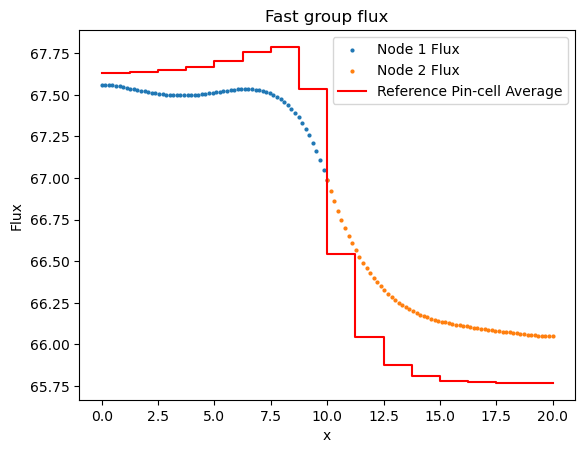

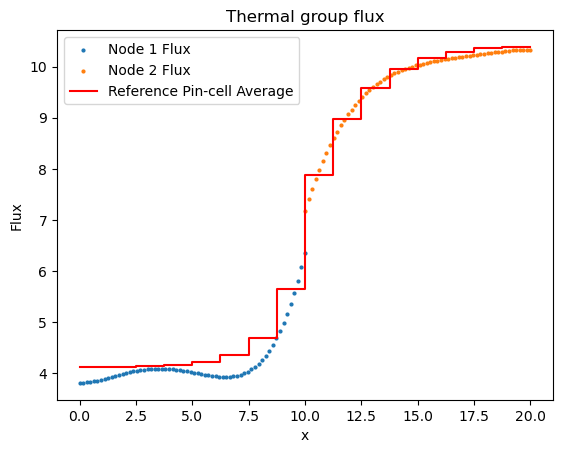

In [320]:
hist1 = np.linspace(0,10,9)
hist2 = np.linspace(10,20,9)
plt.scatter(x1,left_fast, s=4, label="Node 1 Flux")
plt.scatter(x2,right_fast, s=4, label="Node 2 Flux")
#plt.step(hist1, left_fast_avg, color='r', label="Node 1 Pin Cell Average Flux")
#plt.step(hist2, right_fast_avg,color='r')
plt.step(np.linspace(0,20,17), a1_reference_averages[:,0], color="r", where='pre', label="Reference Pin-cell Average")
plt.legend()
plt.title("Fast group flux")
plt.ylabel("Flux")
plt.xlabel("x")
plt.show()
plt.scatter(x1,left_thermal, s=4, label="Node 1 Flux")
plt.scatter(x2,right_thermal, s=4, label="Node 2 Flux")
#plt.step(hist1, left_thermal_avg,color='r', label="Pin Cell Average Flux")
#plt.step(hist2, right_thermal_avg,color='r')
plt.step(np.linspace(0,20,17), a1_reference_averages[:,1], color="r", where='pre', label="Reference Pin-cell Average")
plt.legend()
plt.title("Thermal group flux")
plt.ylabel("Flux")
plt.xlabel("x")
plt.show()

In [321]:
print(current(left_thermal, right_thermal, left_fast, right_fast))

[[ 0.00000000e+00  0.00000000e+00]
 [-1.90009623e-04  8.41627229e-04]
 [-5.34453603e-04  2.36730503e-03]
 [-8.27514111e-04  3.66538548e-03]
 [-1.07183038e-03  4.74755876e-03]
 [-1.27004164e-03  5.62551506e-03]
 [-1.42478712e-03  6.31094455e-03]
 [-1.53870605e-03  6.81553742e-03]
 [-1.61443768e-03  7.15098386e-03]
 [-1.65462122e-03  7.32897404e-03]
 [-1.66189592e-03  7.36119815e-03]
 [-1.63890099e-03  7.25934636e-03]
 [-1.58827569e-03  7.03510887e-03]
 [-1.51265923e-03  6.70017585e-03]
 [-1.41469085e-03  6.26623748e-03]
 [-1.29700979e-03  5.74498395e-03]
 [-1.16225526e-03  5.14810545e-03]
 [-1.01306652e-03  4.48729214e-03]
 [-8.52082781e-04  3.77423423e-03]
 [-6.81943283e-04  3.02062188e-03]
 [-5.05287257e-04  2.23814527e-03]
 [-3.24753936e-04  1.43849461e-03]
 [-1.42982551e-04  6.33360051e-04]
 [ 3.73876653e-05 -1.65568207e-04]
 [ 2.13717481e-04 -9.46599985e-04]
 [ 3.83367664e-04 -1.69804510e-03]
 [ 5.43698983e-04 -2.40821338e-03]
 [ 6.92072205e-04 -3.06541462e-03]
 [ 8.25848098e-04 -3

Problem 2

In [322]:
# initialize classes
flux1 = flux()
fission1 = fission()
lhs1 = lhs()

# nodes
node1 = cell(0,10,a2)
node2 = cell(10,20,u2)

# mesh
mesh1 = mesh(10)

In [323]:
main_loop()

Power iteration:  0
Power iteration:  1
Power iteration:  2
Power iteration:  3
Power iteration:  4
Power iteration:  5
Power iteration:  6
Power iteration:  7
Power iteration:  8
Power iteration:  9
Power iteration:  10
Power iteration:  11
Power iteration:  12
k: 1.5000042322227407


In [324]:
x1 = np.linspace(0,10,64)
x2 = np.linspace(10,20,64)
left_fast = functions.left_fast(x1)
right_fast = functions.right_fast(x2)
left_thermal = functions.left_thermal(x1)
right_thermal = functions.right_thermal(x2)

In [325]:
left_thermal_avg, right_thermal_avg, left_fast_avg, right_fast_avg = get_pin_average(left_thermal, right_thermal, left_fast, right_fast)

In [277]:
a2_reference_averages = np.array([[45.52626187,  7.39610378],
                                  [45.52626187,  7.39610378],
                                  [45.53309566,  7.40662806],
                                  [45.54817388,  7.43462702],
                                  [45.57428883,  7.4989675 ],
                                  [45.61439073,  7.64408391],
                                  [45.6633371 ,  7.97296139],
                                  [45.66546839,  8.72875724],
                                  [45.31190233, 10.54486908],
                                  [44.11991045, 14.1225771 ],
                                  [43.51004085, 16.40553349],
                                  [43.28715688, 17.759332  ],
                                  [43.19582216, 18.58014531],
                                  [43.15661703, 19.07686491],
                                  [43.14009274, 19.37167534],
                                  [43.13364212, 19.53604023],
                                  [43.13155514, 19.60945802]])

In [278]:
relative_error(left_thermal_avg, right_thermal_avg, left_fast_avg, right_fast_avg, a2_reference_averages)

array([[0.06603104, 3.63376999],
       [0.1535421 , 1.21373263],
       [0.24367798, 0.42046693],
       [0.30155704, 0.41549142],
       [0.36548903, 3.11690621],
       [0.52867441, 5.25996199],
       [0.84692984, 4.05188177],
       [0.90030957, 0.19209984],
       [0.58956167, 0.53305137],
       [0.9435225 , 0.34306812],
       [0.84435515, 0.62188124],
       [0.71686563, 0.33963026],
       [0.6234755 , 0.07477088],
       [0.55005164, 0.28497138],
       [0.48334501, 0.17534231],
       [0.43440291, 0.0728752 ]])

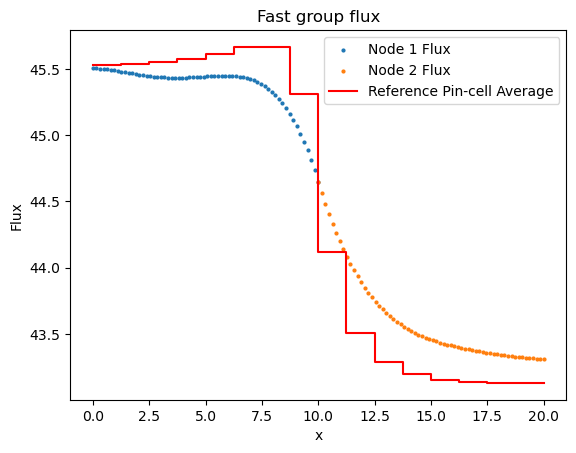

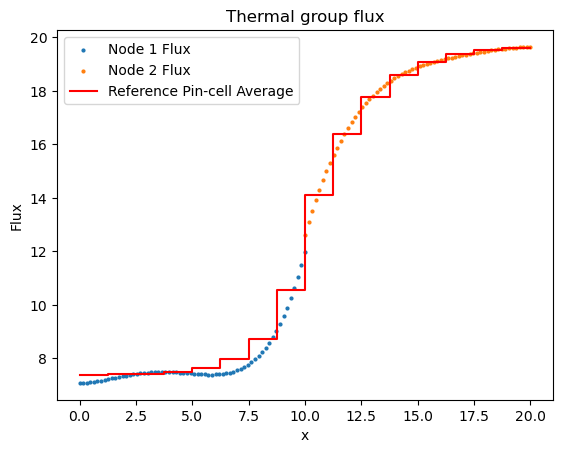

In [279]:
hist1 = np.linspace(0,10,9)
hist2 = np.linspace(10,20,9)
plt.scatter(x1,left_fast, s=4, label="Node 1 Flux")
plt.scatter(x2,right_fast, s=4, label="Node 2 Flux")
#plt.step(hist1, left_fast_avg, color='r', label="Node 1 Pin Cell Average Flux")
#plt.step(hist2, right_fast_avg,color='r')
plt.step(np.linspace(0,20,17), a2_reference_averages[:,0], color="r", where='pre', label="Reference Pin-cell Average")
plt.legend()
plt.title("Fast group flux")
plt.ylabel("Flux")
plt.xlabel("x")
plt.show()
plt.scatter(x1,left_thermal, s=4, label="Node 1 Flux")
plt.scatter(x2,right_thermal, s=4, label="Node 2 Flux")
#plt.step(hist1, left_thermal_avg,color='r', label="Pin Cell Average Flux")
#plt.step(hist2, right_thermal_avg,color='r')
plt.step(np.linspace(0,20,17), a2_reference_averages[:,1], color="r", where='pre', label="Reference Pin-cell Average")
plt.legend()
plt.title("Thermal group flux")
plt.ylabel("Flux")
plt.xlabel("x")
plt.show()

In [280]:
print(current(left_thermal, right_thermal, left_fast, right_fast))

[[ 0.00000000e+00  0.00000000e+00]
 [-1.59824314e-04  9.16705774e-04]
 [-4.49263479e-04  2.57685183e-03]
 [-6.95154152e-04  3.98722680e-03]
 [-8.99850608e-04  5.16133354e-03]
 [-1.06570712e-03  6.11267494e-03]
 [-1.19507797e-03  6.85475384e-03]
 [-1.29031742e-03  7.40107314e-03]
 [-1.35377974e-03  7.76513568e-03]
 [-1.38781923e-03  7.96044435e-03]
 [-1.39479014e-03  8.00050200e-03]
 [-1.37704675e-03  7.89881151e-03]
 [-1.33694334e-03  7.66887575e-03]
 [-1.27683418e-03  7.32419757e-03]
 [-1.19907355e-03  6.87827986e-03]
 [-1.10601571e-03  6.34462548e-03]
 [-1.00001495e-03  5.73673729e-03]
 [-8.83425530e-04  5.06811817e-03]
 [-7.58601735e-04  4.35227098e-03]
 [-6.27897835e-04  3.60269859e-03]
 [-4.93668105e-04  2.83290387e-03]
 [-3.58266819e-04  2.05638969e-03]
 [-2.24048250e-04  1.28665891e-03]
 [-9.33666736e-05  5.37214411e-04]
 [ 3.14236366e-05 -1.78440951e-04]
 [ 1.47968406e-04 -8.46804303e-04]
 [ 2.53913362e-04 -1.45437278e-03]
 [ 3.46904228e-04 -1.98764351e-03]
 [ 4.24586732e-04 -2

Problem 3

In [281]:
# initialize classes
flux1 = flux()
fission1 = fission()
lhs1 = lhs()

# nodes
node1 = cell(0,10,a3)
node2 = cell(10,20,u2)

# mesh
mesh1 = mesh(10)

In [282]:
main_loop()

Power iteration:  0
Power iteration:  1
Power iteration:  2
Power iteration:  3
Power iteration:  4
Power iteration:  5
Power iteration:  6
Power iteration:  7
Power iteration:  8
Power iteration:  9
Power iteration:  10
Power iteration:  11
Power iteration:  12
k: 1.500003591702666


In [283]:
x1 = np.linspace(0,10,64)
x2 = np.linspace(10,20,64)
left_fast = functions.left_fast(x1)
right_fast = functions.right_fast(x2)
left_thermal = functions.left_thermal(x1)
right_thermal = functions.right_thermal(x2)


In [284]:
left_thermal_avg, right_thermal_avg, left_fast_avg, right_fast_avg = get_pin_average(left_thermal, right_thermal, left_fast, right_fast)

In [285]:
a3_reference_averages = np.array([[45.66683405,  7.43817495],
                                  [45.66683405,  7.43817495],
                                  [45.67732664,  7.46293862],
                                  [45.69975655,  7.52950616],
                                  [45.7344616 ,  7.68451349],
                                  [45.76675452,  8.03998528],
                                  [45.69890389,  8.87504648],
                                  [45.29128284, 10.66461325],
                                  [44.62118806, 13.12008786],
                                  [43.84326888, 15.75845225],
                                  [43.4785429 , 17.40555625],
                                  [43.34110096, 18.39193932],
                                  [43.28447489, 18.99170523],
                                  [43.26079522, 19.35523814],
                                  [43.25145347, 19.57126046],
                                  [43.24823931, 19.69181277],
                                  [43.24738733, 19.74569646]])

In [286]:
relative_error(left_thermal_avg, right_thermal_avg, left_fast_avg, right_fast_avg, a3_reference_averages)

array([[ 0.28426329,  7.00954032],
       [ 0.35409232,  8.28131781],
       [ 0.44100841,  8.63101629],
       [ 0.52105502,  6.59191991],
       [ 0.58551963,  1.69519152],
       [ 0.49310303,  6.26309911],
       [ 0.16518197, 16.28425018],
       [ 1.07327587, 20.4679066 ],
       [ 0.52015971,  0.4476053 ],
       [ 0.62900252,  0.58268353],
       [ 0.51853082,  0.50841549],
       [ 0.41373722,  0.16467324],
       [ 0.34052652,  0.21093261],
       [ 0.28458998,  0.41090436],
       [ 0.23538689,  0.36657936],
       [ 0.20007102,  0.20921274]])

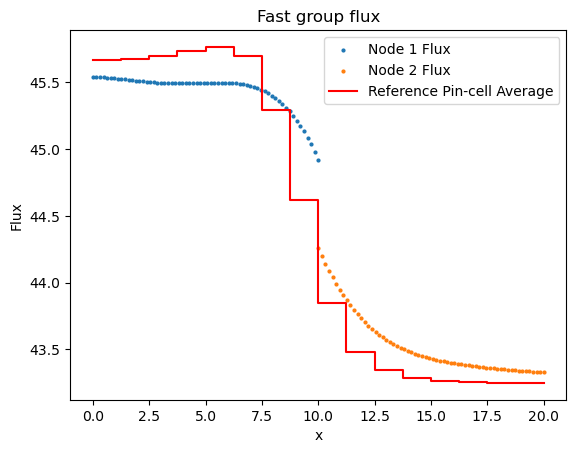

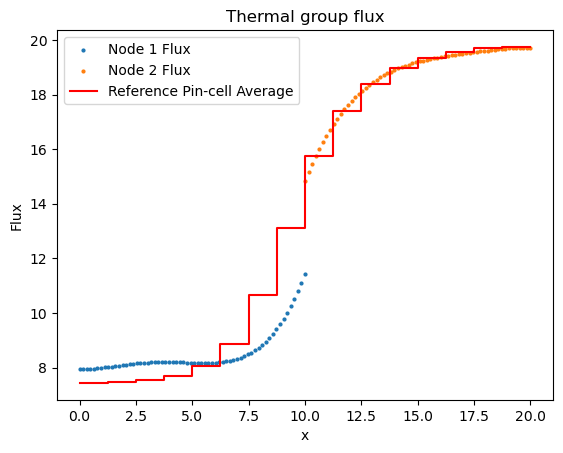

In [287]:
hist1 = np.linspace(0,10,9)
hist2 = np.linspace(10,20,9)
plt.scatter(x1,left_fast, s=4, label="Node 1 Flux")
plt.scatter(x2,right_fast, s=4, label="Node 2 Flux")
#plt.step(hist1, left_fast_avg, color='r', label="Node 1 Pin Cell Average Flux")
#plt.step(hist2, right_fast_avg,color='r')
plt.step(np.linspace(0,20,17), a3_reference_averages[:,0], color="r", where='pre', label="Reference Pin-cell Average")
plt.legend()
plt.title("Fast group flux")
plt.ylabel("Flux")
plt.xlabel("x")
plt.show()
plt.scatter(x1,left_thermal, s=4, label="Node 1 Flux")
plt.scatter(x2,right_thermal, s=4, label="Node 2 Flux")
#plt.step(hist1, left_thermal_avg,color='r', label="Pin Cell Average Flux")
#plt.step(hist2, right_thermal_avg,color='r')
plt.step(np.linspace(0,20,17), a3_reference_averages[:,1], color="r", where='pre', label="Reference Pin-cell Average")
plt.legend()
plt.title("Thermal group flux")
plt.ylabel("Flux")
plt.xlabel("x")
plt.show()

In [288]:
print(current(left_thermal, right_thermal, left_fast, right_fast))

[[ 0.00000000e+00  0.00000000e+00]
 [-1.04646425e-04  5.92750856e-04]
 [-2.94169136e-04  1.66627427e-03]
 [-4.55215781e-04  2.57850892e-03]
 [-5.89358548e-04  3.33835967e-03]
 [-6.98169624e-04  3.95473143e-03]
 [-7.83221197e-04  4.43652908e-03]
 [-8.46085454e-04  4.79265750e-03]
 [-8.88334583e-04  5.03202158e-03]
 [-9.11540772e-04  5.16352621e-03]
 [-9.17276208e-04  5.19607628e-03]
 [-9.07113079e-04  5.13857667e-03]
 [-8.82623573e-04  4.99993227e-03]
 [-8.45379877e-04  4.78904798e-03]
 [-7.96954178e-04  4.51482867e-03]
 [-7.38918665e-04  4.18617923e-03]
 [-6.72845524e-04  3.81200455e-03]
 [-6.00306945e-04  3.40120952e-03]
 [-5.22875113e-04  2.96269903e-03]
 [-4.42122218e-04  2.50537796e-03]
 [-3.59620446e-04  2.03815120e-03]
 [-2.76941985e-04  1.56992364e-03]
 [-1.95659022e-04  1.10960016e-03]
 [-1.17343746e-04  6.66085657e-04]
 [-4.35683442e-05  2.48285011e-04]
 [ 2.40949962e-05 -1.34896888e-04]
 [ 8.40740876e-05 -4.74555153e-04]
 [ 1.34796742e-04 -7.61784896e-04]
 [ 1.74690772e-04 -9